In [1]:
import pandas 
import pyrosetta 
from sklearn import preprocessing, svm, ensemble, model_selection, metrics, manifold, decomposition
from rosetta import protocols, core 
from Bio.Data import IUPACData
import matplotlib.pyplot as plt 
import numpy as np 
%matplotlib inline

In [2]:
plt.style.use('seaborn-deep')

In [3]:
df = pandas.read_csv('../data_sets/speculative_targets.csv', index_col=0)
df.drop('BglB', axis=0, inplace=True)
df.sample(5)

,kcat,km,kcatkm,expression
mutant_name,,,,
W407G,NaN,NaN,NaN,0
R240D,-0.494234,0.335257,-0.824025,1
I244N,-0.511513,-0.366532,-0.139572,1
N220D,-1.371611,-0.119186,-1.247461,1
L171D,-2.015064,-0.236572,-1.773528,1


In [4]:
df.shape

(145, 4)

In [5]:
BASE_DIR = '/Users/alex/Documents/bglb_family/pipeline/'
pyrosetta.init('-beta -extra_res_fa ../pipeline/comparative_modeling/pnpg.params -preserve_header')

Found rosetta database at: /Users/alex/anaconda3/envs/rose/lib/python3.5/site-packages/pyrosetta-4.0-py3.5.egg/database; using it....
PyRosetta-4 2016 [Rosetta 2016 unknown:94998f0e5b038b6d8083995a664cb96641cb844b 2017-05-11 15:10:16 -0500] retrieved from: git@github.com:RosettaCommons/main.git
(C) Copyright Rosetta Commons Member Institutions.
Created in JHU by Sergey Lyskov and PyRosetta Team.



In [6]:
p = pyrosetta.pose_from_file('../pipeline/output_files/2888/native.pdb')
cst = protocols.enzdes.AddOrRemoveMatchCsts()
cst.set_cst_action(protocols.enzdes.ADD_NEW)
cst.cstfile('../pipeline/output_files/2888/pnpg.cst')
cst.apply(p)
s = pyrosetta.create_score_function('beta_cst')
s(p)

-1402.010406123926

In [7]:
cst_set = p.constraint_set()
res_with_cst = []
for n in cst_set.get_all_constraints():
    for r in n.residues():
        if r not in res_with_cst:
            res_with_cst.append(r)
            # gives us deterministic order (instead of set) 

res_with_cst

[480, 178, 383, 309]

In [8]:
# we can infer the chemical function of these by ordering them 
chem = ['acid_base', 'backup', 'nucleophile', 'ligand']
dict(zip(sorted(res_with_cst), chem))

{178: 'acid_base', 309: 'backup', 383: 'nucleophile', 480: 'ligand'}

In [9]:
nonzero_score_types = s.get_nonzero_weighted_scoretypes()

nonzero_score_types

vector1_core_scoring_ScoreType[fa_atr, fa_rep, fa_sol, fa_intra_atr_xover4, fa_intra_rep_xover4, fa_intra_sol_xover4, lk_ball, lk_ball_iso, lk_ball_bridge, lk_ball_bridge_uncpl, fa_elec, fa_intra_elec, pro_close, hbond_sr_bb, hbond_lr_bb, hbond_bb_sc, hbond_sc, dslf_fa13, atom_pair_constraint, coordinate_constraint, angle_constraint, dihedral_constraint, omega, fa_dun_dev, fa_dun_rot, fa_dun_semi, p_aa_pp, hxl_tors, ref, chainbreak, rama_prepro, res_type_constraint]

In [10]:
#for n, residue_pos in enumerate(sorted(res_with_cst), 1):
features = {}
en = p.energies()
d = dict(zip(sorted(res_with_cst), chem))
for k, v in d.items():
    for st in nonzero_score_types:
        name = core.scoring.name_from_score_type(st) 
        energy = en.residue_total_energies(k)[st]
        features.update({name: energy})
        #print('{}__{}'.format(v, name), energy)
    features.update({'{}__position'.format(v): k})
len(features)

36

In [11]:
features

{'acid_base__position': 178,
 'angle_constraint': 0.19317785052071523,
 'atom_pair_constraint': 0.06593128710226558,
 'backup__position': 309,
 'chainbreak': 0.0,
 'coordinate_constraint': 0.0,
 'dihedral_constraint': 0.026139638794694355,
 'dslf_fa13': 0.0,
 'fa_atr': -8.557156223083636,
 'fa_dun_dev': 1.0369735397579316,
 'fa_dun_rot': 0.0,
 'fa_dun_semi': 5.583484336874597,
 'fa_elec': -3.717117955347686,
 'fa_intra_atr_xover4': -0.1793307814742469,
 'fa_intra_elec': -0.45534360846361577,
 'fa_intra_rep_xover4': 0.005714665240062907,
 'fa_intra_sol_xover4': 0.24033860637916388,
 'fa_rep': 4.05114004364606,
 'fa_sol': 10.226297090063387,
 'hbond_bb_sc': 0.0,
 'hbond_lr_bb': 0.0,
 'hbond_sc': -1.071626535194667,
 'hbond_sr_bb': 0.0,
 'hxl_tors': 0.0,
 'ligand__position': 480,
 'lk_ball': 5.259450224127169,
 'lk_ball_bridge': 0.03129901112090718,
 'lk_ball_bridge_uncpl': 0.1909812230222458,
 'lk_ball_iso': 10.933055380453265,
 'nucleophile__position': 383,
 'omega': 2.1286001364338905,

In [12]:
def deep_mutational_scan():
    
    for mutant_name in df.index:
        
        # make mutant 
        pose = p.clone()
        native, *pos, design = mutant_name 
        pos = int(''.join(pos))
        design = IUPACData.protein_letters_1to3[design].upper()
        mutate = protocols.simple_moves.MutateResidue(pos, design) 
        _ = s(pose)
        score_begin = [pose.energies().total_energies()[n] for n in s.get_nonzero_weighted_scoretypes()] #WT
        mutate.apply(pose)
        
        # conformational sampling 
        tf = core.pack.task.TaskFactory()
        around = protocols.toolbox.task_operations.DesignAroundOperation()
        around.include_residue(pos)
        around.repack_shell(8.0) 
        around.resnums_allow_design(False)
        around.allow_design(False)
        tf.push_back(around) 
        pt = tf.create_task_and_apply_taskoperations(pose)
        repack = protocols.simple_moves.PackRotamersMover(s, pt)
        repack.apply(pose)
        _ = s(pose) 
        
        # features 
        features = {}
        en = pose.energies()
        d = dict(zip(sorted(res_with_cst), chem))
        for k, v in d.items():
            for st in nonzero_score_types:
                name = core.scoring.name_from_score_type(st) 
                energy = en.residue_total_energies(k)[st]
                feature_name = '{}__{}'.format(v, name)
                features.update({feature_name: energy})
                #print('{}__{}'.format(v, name), energy)
            features.update({'{}__position'.format(v): k})
        yield features 
        
#list_of_score_type_names = [str(n).replace('ScoreType.', '') for n in s.get_nonzero_weighted_scoretypes()]
features = pandas.DataFrame(list(deep_mutational_scan()), index=df.index)
features.head()

,acid_base__angle_constraint,acid_base__atom_pair_constraint,acid_base__chainbreak,acid_base__coordinate_constraint,acid_base__dihedral_constraint,acid_base__dslf_fa13,acid_base__fa_atr,acid_base__fa_dun_dev,acid_base__fa_dun_rot,acid_base__fa_dun_semi,...,nucleophile__lk_ball_bridge,nucleophile__lk_ball_bridge_uncpl,nucleophile__lk_ball_iso,nucleophile__omega,nucleophile__p_aa_pp,nucleophile__position,nucleophile__pro_close,nucleophile__rama_prepro,nucleophile__ref,nucleophile__res_type_constraint
mutant_name,,,,,,,,,,,,,,,,,,,,,
S14A,0.001868,0.0,0.0,0.0,0.013679,0.0,-9.556874,0.582336,0.0,3.523524,...,0.031299,0.190981,10.933055,2.1286,0.026322,383,0.0,0.158629,-2.7348,0.0
T15A,0.001868,0.0,0.0,0.0,0.013679,0.0,-9.556874,0.582336,0.0,3.523524,...,0.031299,0.190981,10.933055,2.1286,0.026322,383,0.0,0.158629,-2.7348,0.0
S16A,0.001868,0.0,0.0,0.0,0.013679,0.0,-9.556874,0.582336,0.0,3.523524,...,0.031299,0.190981,10.933055,2.1286,0.026322,383,0.0,0.158629,-2.7348,0.0
S17A,0.001868,0.0,0.0,0.0,0.013679,0.0,-9.556874,0.582336,0.0,3.523524,...,0.031299,0.190981,10.933055,2.1286,0.026322,383,0.0,0.158629,-2.7348,0.0
S17E,0.001868,0.0,0.0,0.0,0.013679,0.0,-9.556874,0.582336,0.0,3.523524,...,0.031299,0.190981,10.933055,2.1286,0.026322,383,0.0,0.158629,-2.7348,0.0


In [13]:
features.shape

(145, 132)

In [14]:
features.columns

Index(['acid_base__angle_constraint', 'acid_base__atom_pair_constraint',
       'acid_base__chainbreak', 'acid_base__coordinate_constraint',
       'acid_base__dihedral_constraint', 'acid_base__dslf_fa13',
       'acid_base__fa_atr', 'acid_base__fa_dun_dev', 'acid_base__fa_dun_rot',
       'acid_base__fa_dun_semi',
       ...
       'nucleophile__lk_ball_bridge', 'nucleophile__lk_ball_bridge_uncpl',
       'nucleophile__lk_ball_iso', 'nucleophile__omega',
       'nucleophile__p_aa_pp', 'nucleophile__position',
       'nucleophile__pro_close', 'nucleophile__rama_prepro',
       'nucleophile__ref', 'nucleophile__res_type_constraint'],
      dtype='object', length=132)

In [15]:
# clean up features a bit 
drop_me = []
for feature in features:
    if features[feature].std() == 0.0:
        drop_me.append(feature)

features.drop(drop_me, axis=1, inplace=1) 
features.shape

(145, 83)

**Result: dropping features with `variance == 0.0` reduces feature count from 32 to 26**. This leaves sample size (145) unchanged. 

In [16]:
features.head()

,acid_base__angle_constraint,acid_base__atom_pair_constraint,acid_base__dihedral_constraint,acid_base__fa_atr,acid_base__fa_dun_dev,acid_base__fa_dun_rot,acid_base__fa_dun_semi,acid_base__fa_elec,acid_base__fa_intra_atr_xover4,acid_base__fa_intra_elec,...,nucleophile__fa_sol,nucleophile__hbond_sc,nucleophile__lk_ball,nucleophile__lk_ball_bridge,nucleophile__lk_ball_bridge_uncpl,nucleophile__lk_ball_iso,nucleophile__omega,nucleophile__p_aa_pp,nucleophile__rama_prepro,nucleophile__ref
mutant_name,,,,,,,,,,,,,,,,,,,,,
S14A,0.001868,0.0,0.013679,-9.556874,0.582336,0.0,3.523524,-4.480659,-0.267133,-0.281258,...,10.226297,-1.071627,5.25945,0.031299,0.190981,10.933055,2.1286,0.026322,0.158629,-2.7348
T15A,0.001868,0.0,0.013679,-9.556874,0.582336,0.0,3.523524,-4.480659,-0.267133,-0.281258,...,10.226297,-1.071627,5.25945,0.031299,0.190981,10.933055,2.1286,0.026322,0.158629,-2.7348
S16A,0.001868,0.0,0.013679,-9.556874,0.582336,0.0,3.523524,-4.480659,-0.267133,-0.281258,...,10.226297,-1.071627,5.25945,0.031299,0.190981,10.933055,2.1286,0.026322,0.158629,-2.7348
S17A,0.001868,0.0,0.013679,-9.556874,0.582336,0.0,3.523524,-4.480659,-0.267133,-0.281258,...,10.226297,-1.071627,5.25945,0.031299,0.190981,10.933055,2.1286,0.026322,0.158629,-2.7348
S17E,0.001868,0.0,0.013679,-9.556874,0.582336,0.0,3.523524,-4.480659,-0.267133,-0.281258,...,10.226297,-1.071627,5.25945,0.031299,0.190981,10.933055,2.1286,0.026322,0.158629,-2.7348


In [17]:
from sklearn import linear_model

In [18]:
targets = 'kcat km kcatkm'.split()
results = {}
scaler = preprocessing.StandardScaler()
for target_name in targets:
    J = df[[target_name]].join(features).dropna()
    c = J.corr()[[target_name]].drop([target_name], axis=0)
    c.columns = ['r']
    c['abs_r'] = c.r.map(abs) 
    c = c.sort_values('abs_r', ascending=False)
    print(c.head(5))
    X = scaler.fit_transform(J.iloc[:, 1:])
    y = J.iloc[:, 0].ravel()
    print(target_name, J.shape, X.shape, y.shape)
    clf = linear_model.ElasticNetCV(l1_ratio=[0.5, 0.9], cv=10, max_iter=1e5)
    clf.fit(X, y) 
    preds = clf.predict(X)
    pkg = {'y': y, 'pred': preds}
    results.update({target_name: pkg})

                               r     abs_r
backup__fa_elec        -0.160575  0.160575
backup__fa_atr         -0.159707  0.159707
acid_base__rama_prepro  0.156187  0.156187
acid_base__fa_rep       0.147509  0.147509
nucleophile__hbond_sc   0.144601  0.144601
kcat (118, 84) (118, 83) (118,)
                            r     abs_r
backup__lk_ball_iso -0.249992  0.249992
backup__lk_ball     -0.249054  0.249054
backup__fa_sol      -0.247021  0.247021
backup__fa_elec      0.237394  0.237394
backup__fa_atr       0.226428  0.226428
km (118, 84) (118, 83) (118,)
                            r     abs_r
backup__fa_elec     -0.216691  0.216691
backup__fa_atr      -0.211008  0.211008
backup__lk_ball_iso  0.205523  0.205523
backup__lk_ball      0.202632  0.202632
backup__fa_sol       0.189564  0.189564
kcatkm (118, 84) (118, 83) (118,)


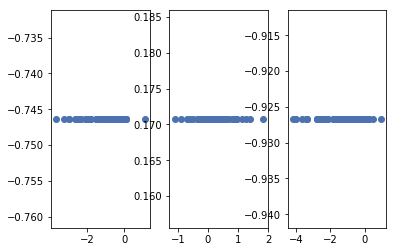

In [19]:
# plot results 
fig, ax = plt.subplots(1, 3)
for n, target_name in enumerate(targets):
    data = results[target_name]
    ax[n].scatter(data['y'], data['pred']) 